# Red Wine Draft 13

# Libraries

In [337]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
import datetime
import sqlite3
import imblearn


from IPython.display import display
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

# Display Parameters

## Display Features

In [338]:
%matplotlib inline
pd.options.display.max_rows = 300000
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 500
pd.set_option("display.float_format", lambda x: "%.3f" % x)

## Colors

In [339]:
color_1 = "bisque"
color_2 = "crimson"
color_3 = "orangered"
color_4 = "lightcoral"
color_5 = "royalblue"
color_6 = "pink"
color_7 = "indianred"
color_8 = "slategrey"
color_9 = "salmon"

## Figure Parameters

In [340]:
size = 20

params = {
    "font.family": "Times New Roman",
    "font.size": size,
    "axes.labelsize": size,
    "xtick.labelsize": size * 0.75,
    "ytick.labelsize": size * 0.75,
    "figure.titlesize": size * 1.5,
    "axes.titlesize": size * 1.5,
    "axes.titlepad": size,
    "axes.labelpad": size - 10,
    "lines.linewidth": 2,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.spines.left": False,
    "axes.spines.bottom": False,
    "legend.fontsize": size,
}

# Goal

Determine which physiochemical properties make a wine "good."

# Load Raw Data

In [341]:
redwine = pd.read_csv(
    "C:\\Users\\Space\\Documents\\py\\Projects\\TuringCollege\\RedWine\\DataSets\\winequality-red.csv",
    index_col=False,
)

In [342]:
redwine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.400,0.700,0.000,1.900,0.076,11.000,34.000,0.998,3.510,0.560,9.400,5
1,7.800,0.880,0.000,2.600,0.098,25.000,67.000,0.997,3.200,0.680,9.800,5
2,7.800,0.760,0.040,2.300,0.092,15.000,54.000,0.997,3.260,0.650,9.800,5
3,11.200,0.280,0.560,1.900,0.075,17.000,60.000,0.998,3.160,0.580,9.800,6
4,7.400,0.700,0.000,1.900,0.076,11.000,34.000,0.998,3.510,0.560,9.400,5


# Exploratory Data Analysis

## Dimensions

In [343]:
redwine.shape

(1599, 12)

## Data Types

In [344]:
redwine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


## Descriptive Statistics

In [345]:
redwine.describe(include="all").applymap("{:,.2f}".format)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,"1,599.00","1,599.00","1,599.00","1,599.00","1,599.00","1,599.00","1,599.00","1,599.00","1,599.00","1,599.00","1,599.00","1,599.00"
mean,8.32,0.53,0.27,2.54,0.09,15.87,46.47,1.00,3.31,0.66,10.42,5.64
std,1.74,0.18,0.19,1.41,0.05,10.46,32.90,0.00,0.15,0.17,1.07,0.81
min,4.60,0.12,0.00,0.90,0.01,1.00,6.00,0.99,2.74,0.33,8.40,3.00
25%,7.10,0.39,0.09,1.90,0.07,7.00,22.00,1.00,3.21,0.55,9.50,5.00
50%,7.90,0.52,0.26,2.20,0.08,14.00,38.00,1.00,3.31,0.62,10.20,6.00
75%,9.20,0.64,0.42,2.60,0.09,21.00,62.00,1.00,3.40,0.73,11.10,6.00
max,15.90,1.58,1.00,15.50,0.61,72.00,289.00,1.00,4.01,2.00,14.90,8.00


## Quality Column

In [346]:
redwine.quality.unique()

array([5, 6, 7, 4, 8, 3], dtype=int64)

In [347]:
quality_counts = redwine["quality"].value_counts()
quality_counts = quality_counts.to_frame()
quality_counts.index.names = ["Quality"]
quality_counts.rename(columns={"quality": "Count"}, inplace=True)
quality_counts = quality_counts.reset_index()

,Quality,Count
0,5,681
1,6,638
2,7,199
3,4,53
4,8,18
5,3,10


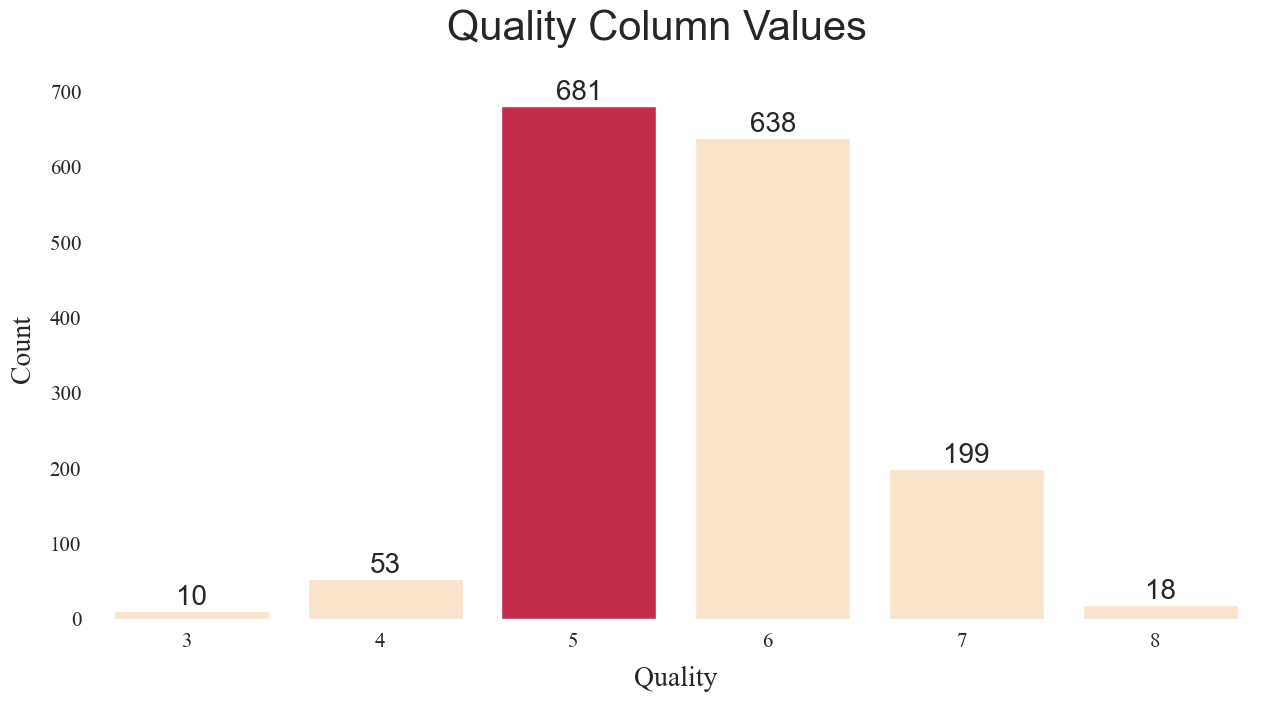

In [348]:
plt.rcParams.update(params)

fig, axes = plt.subplots(1, 1, figsize=(15, 7))
sns.set(style="white")

chart = sns.barplot(
    ax=axes,
    x="Quality",
    y="Count",
    data=quality_counts,
    errorbar=None,
    palette=[color_1 if x != 7 else color_2 for x in quality_counts["Quality"]],
)

chart.bar_label(chart.containers[0], size=size)

plt.xlabel("Quality")
plt.ylabel("Count")
plt.xticks()
plt.yticks()

chart.set_xticklabels(chart.get_xticklabels(), horizontalalignment="right")
plt.suptitle("Quality Column Values")

plt.show()

## Correlations

###  All Quality Categories

Text(158.91666666666666, 0.5, '')

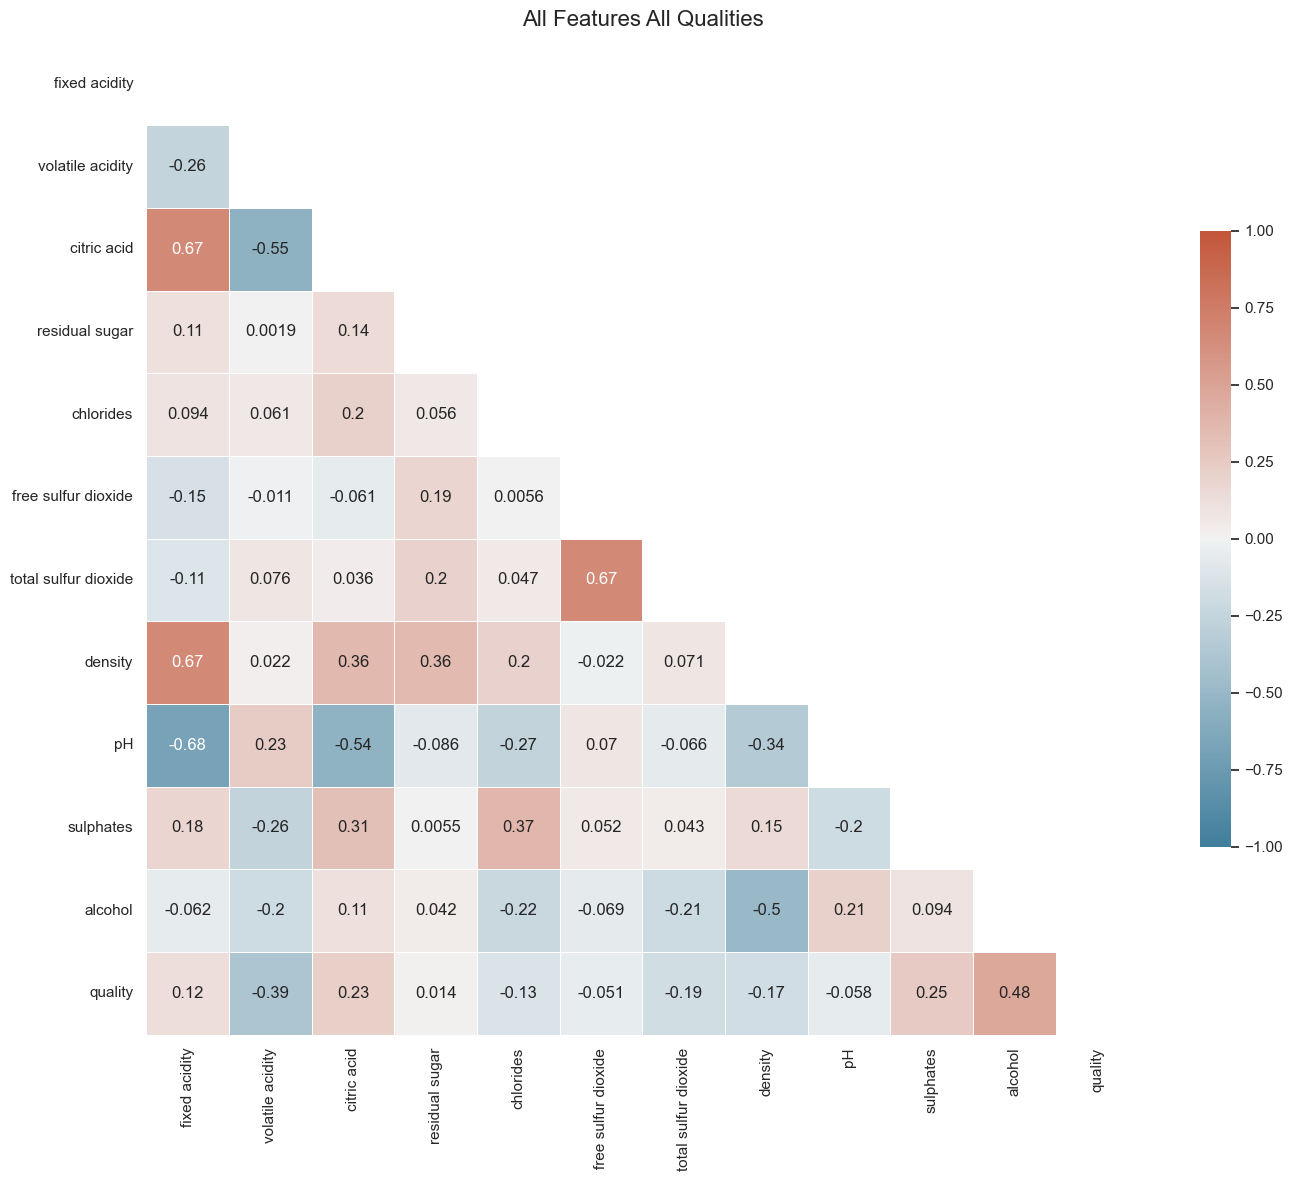

In [349]:
corr = redwine.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(16, 16))

cmap = sns.diverging_palette(230, 20, as_cmap=True)
heatmap = sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=1,
    vmin=-1,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    annot=True,
)

heatmap.set_title(
    "All Features All Qualities",
    fontdict={"fontsize": 16},
    pad=12,
)
plt.xlabel("")
plt.ylabel("")

### Quality 3 Category

In [350]:
three = redwine[redwine["quality"] == 3]

Text(158.91666666666666, 0.5, '')

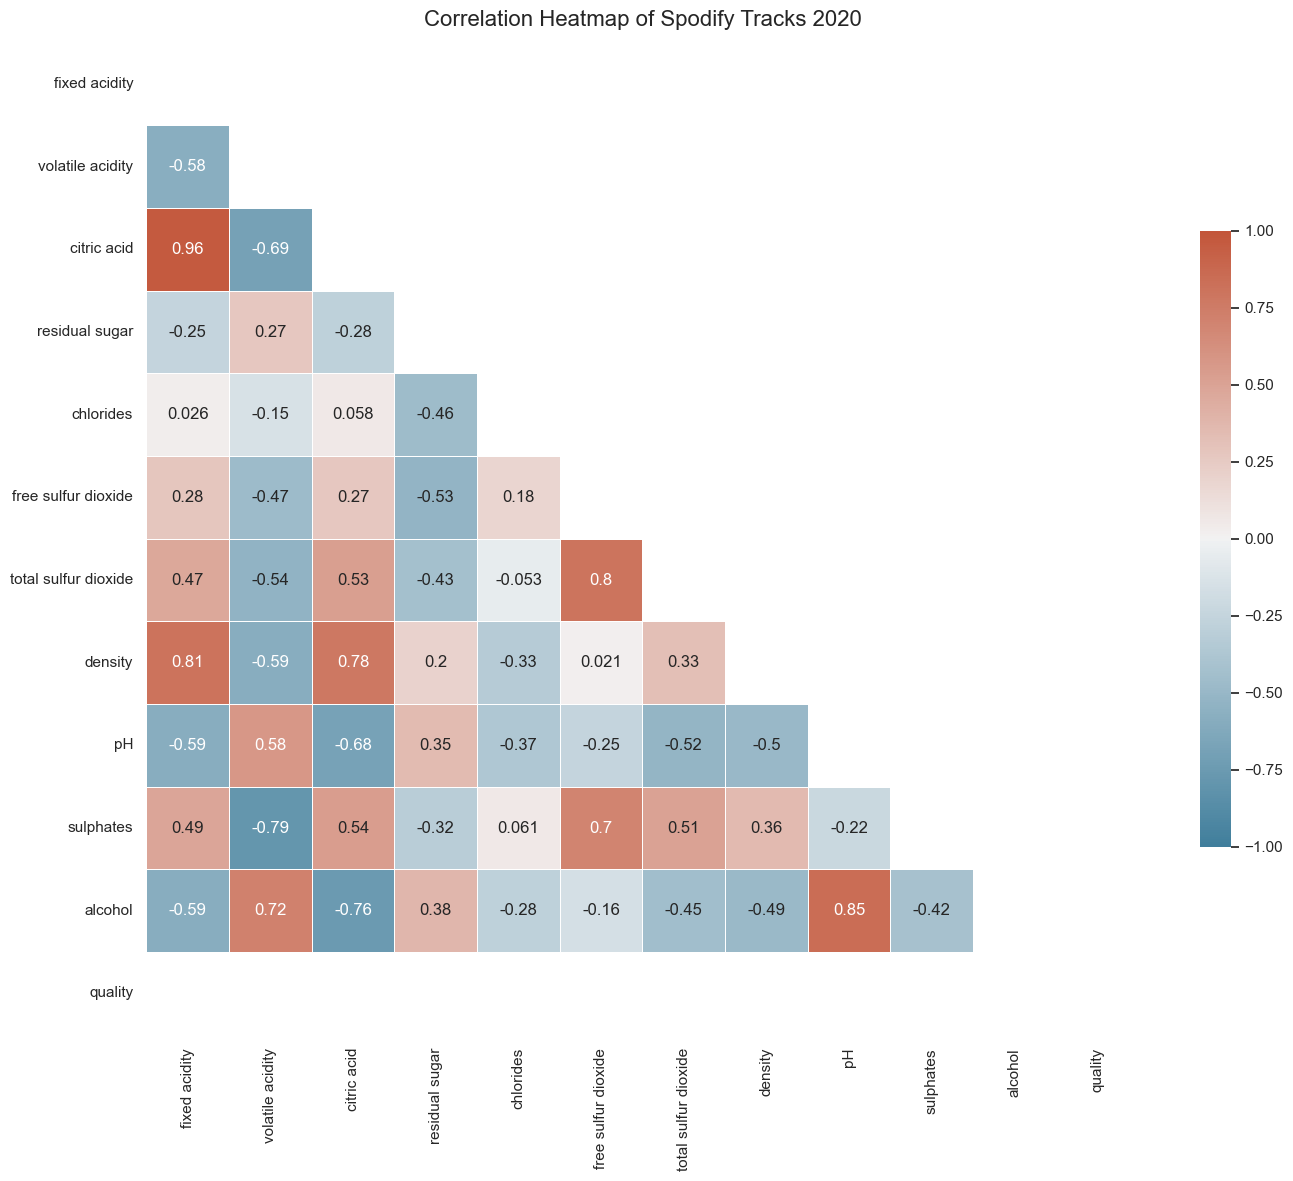

In [351]:
corr = three.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(16, 16))

cmap = sns.diverging_palette(230, 20, as_cmap=True)
heatmap = sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=1,
    vmin=-1,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    annot=True,
)

heatmap.set_title(
    "Correlation Heatmap of Spodify Tracks 2020",
    fontdict={"fontsize": 16},
    pad=12,
)
plt.xlabel("")
plt.ylabel("")

### Quality 4 Category

In [352]:
four = redwine[redwine["quality"] == 4]

Text(158.91666666666666, 0.5, '')

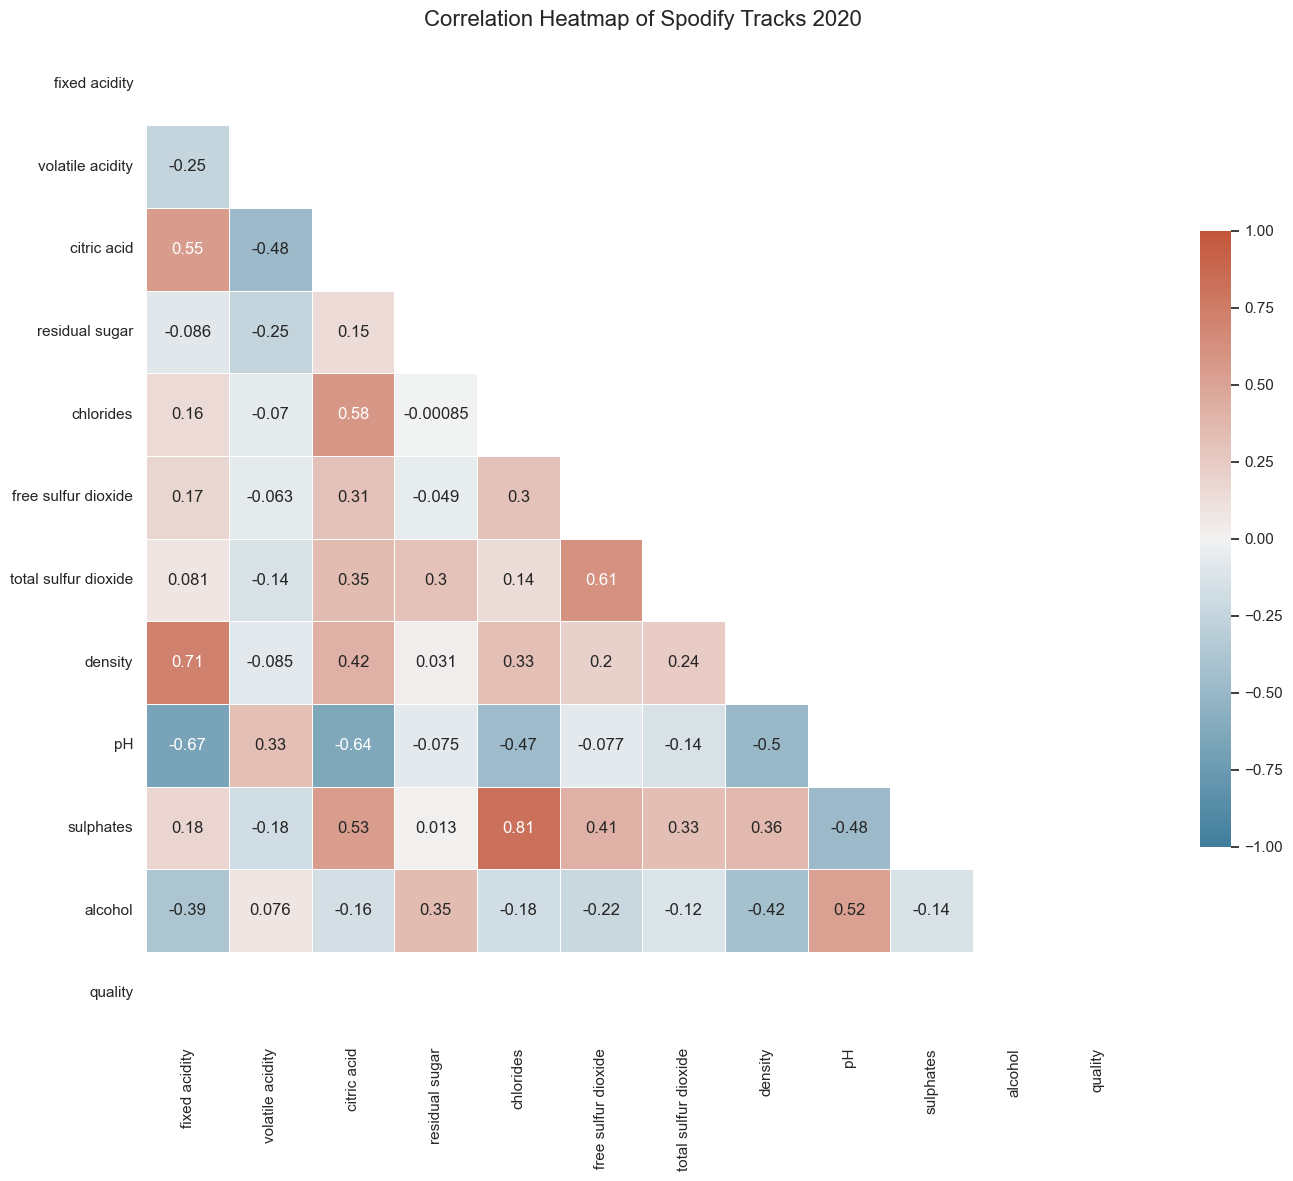

In [353]:
corr = four.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(16, 16))

cmap = sns.diverging_palette(230, 20, as_cmap=True)
heatmap = sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=1,
    vmin=-1,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    annot=True,
)

heatmap.set_title(
    "Correlation Heatmap of Spodify Tracks 2020",
    fontdict={"fontsize": 16},
    pad=12,
)
plt.xlabel("")
plt.ylabel("")

### Quality 5 Category

In [354]:
five = redwine[redwine["quality"] == 5]

Text(158.91666666666666, 0.5, '')

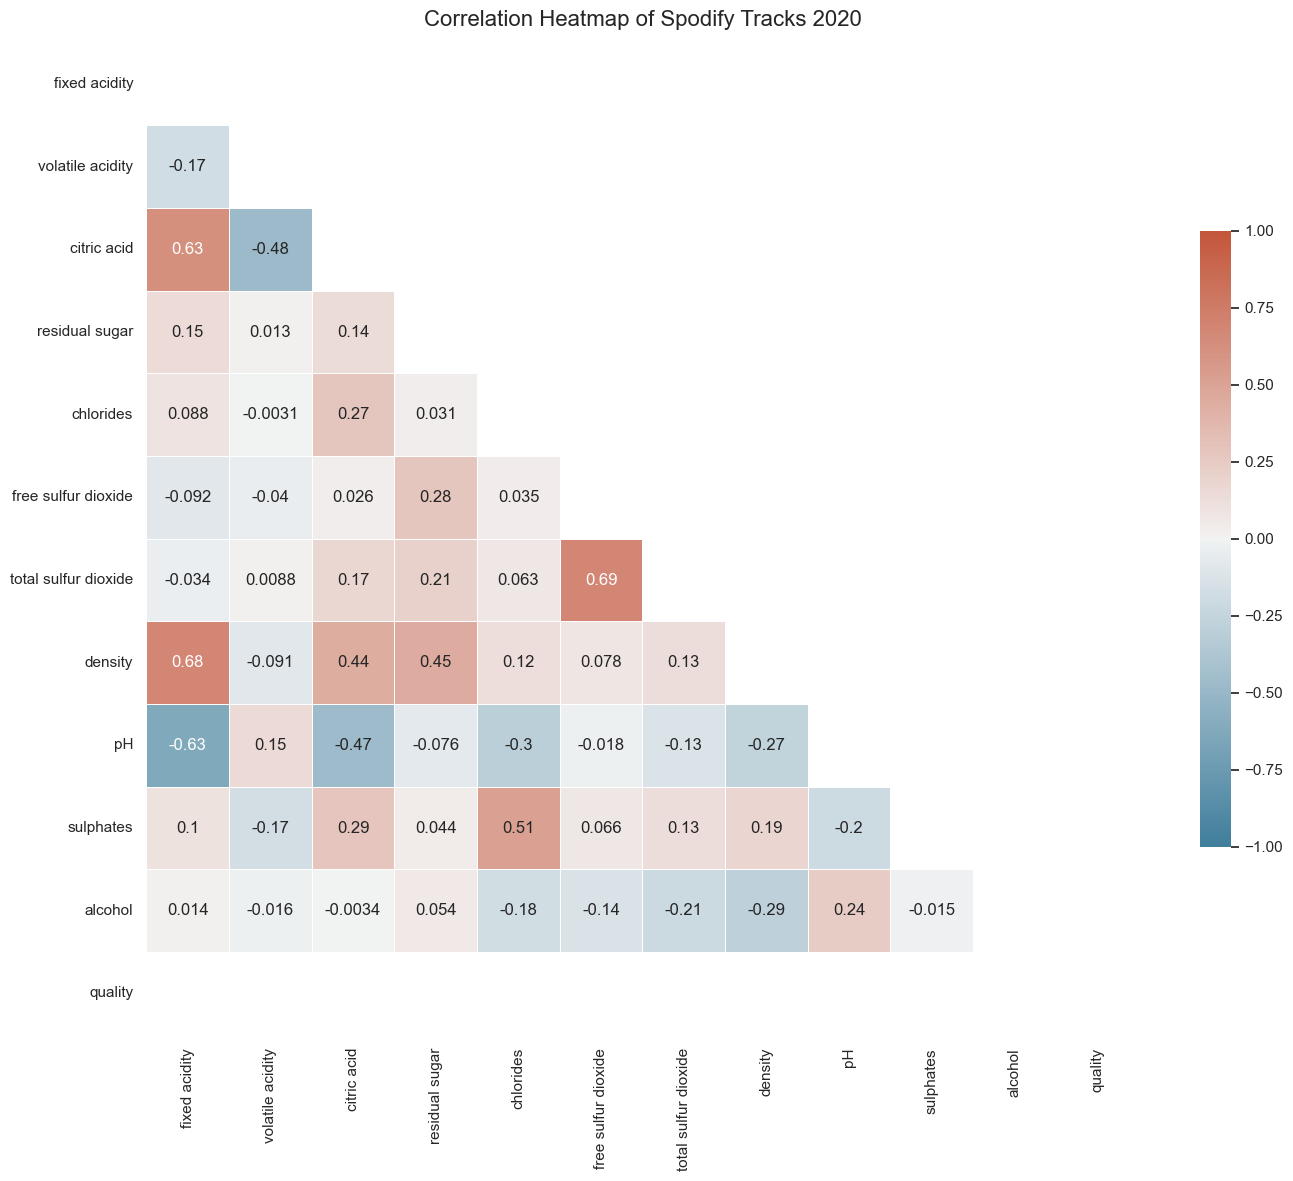

In [355]:
corr = five.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(16, 16))

cmap = sns.diverging_palette(230, 20, as_cmap=True)
heatmap = sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=1,
    vmin=-1,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    annot=True,
)

heatmap.set_title(
    "Correlation Heatmap of Spodify Tracks 2020",
    fontdict={"fontsize": 16},
    pad=12,
)
plt.xlabel("")
plt.ylabel("")

### Quality 6 Category

In [356]:
six = redwine[redwine["quality"] == 6]

Text(158.91666666666666, 0.5, '')

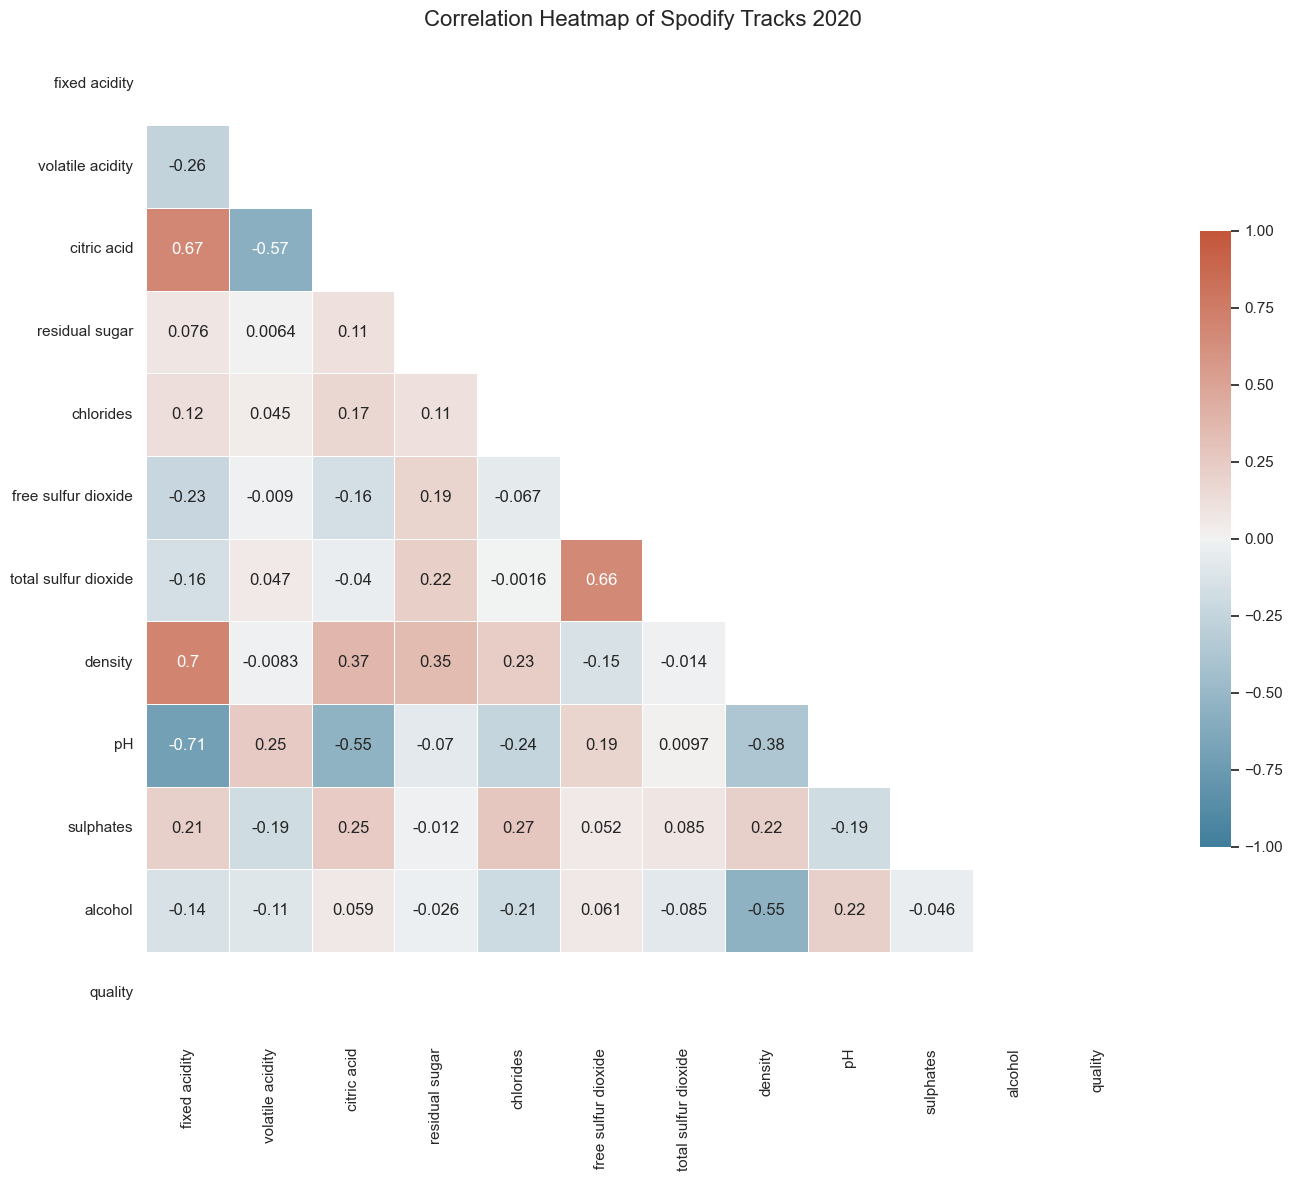

In [357]:
corr = six.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(16, 16))

cmap = sns.diverging_palette(230, 20, as_cmap=True)
heatmap = sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=1,
    vmin=-1,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    annot=True,
)

heatmap.set_title(
    "Correlation Heatmap of Spodify Tracks 2020",
    fontdict={"fontsize": 16},
    pad=12,
)
plt.xlabel("")
plt.ylabel("")

### Quality 7 Category

In [358]:
seven = redwine[redwine["quality"] == 7]

Text(158.91666666666666, 0.5, '')

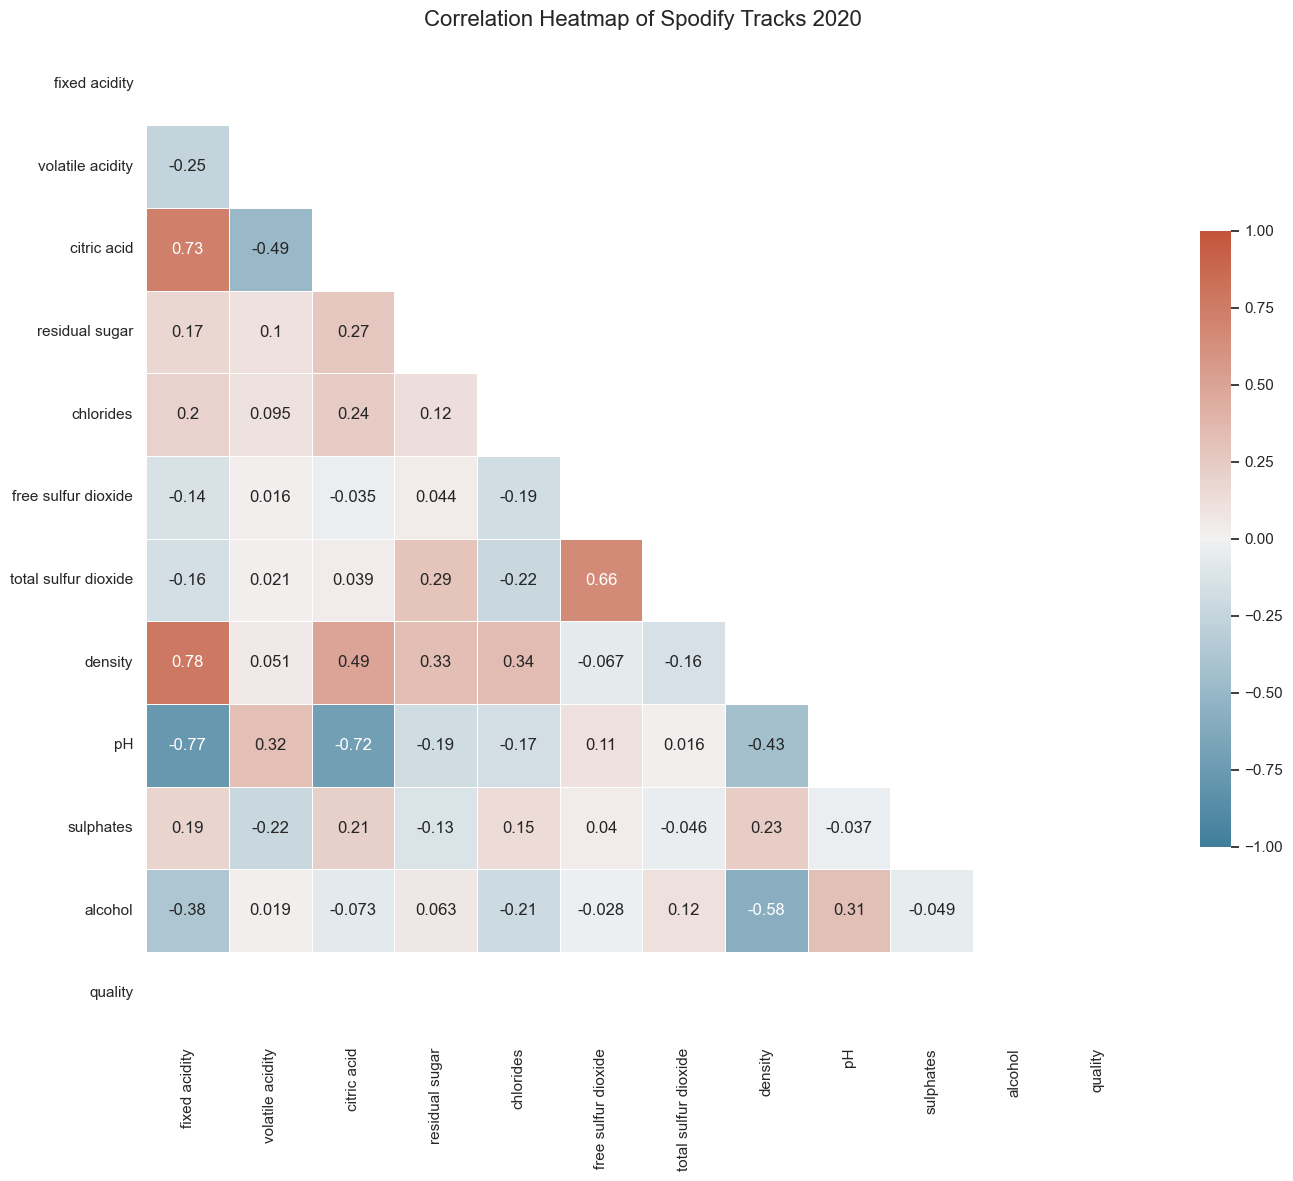

In [359]:
corr = seven.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(16, 16))

cmap = sns.diverging_palette(230, 20, as_cmap=True)
heatmap = sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=1,
    vmin=-1,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    annot=True,
)

heatmap.set_title(
    "Correlation Heatmap of Spodify Tracks 2020",
    fontdict={"fontsize": 16},
    pad=12,
)
plt.xlabel("")
plt.ylabel("")

### Quality 8 Category

In [360]:
eight = redwine[redwine["quality"] == 8]

Text(158.91666666666666, 0.5, '')

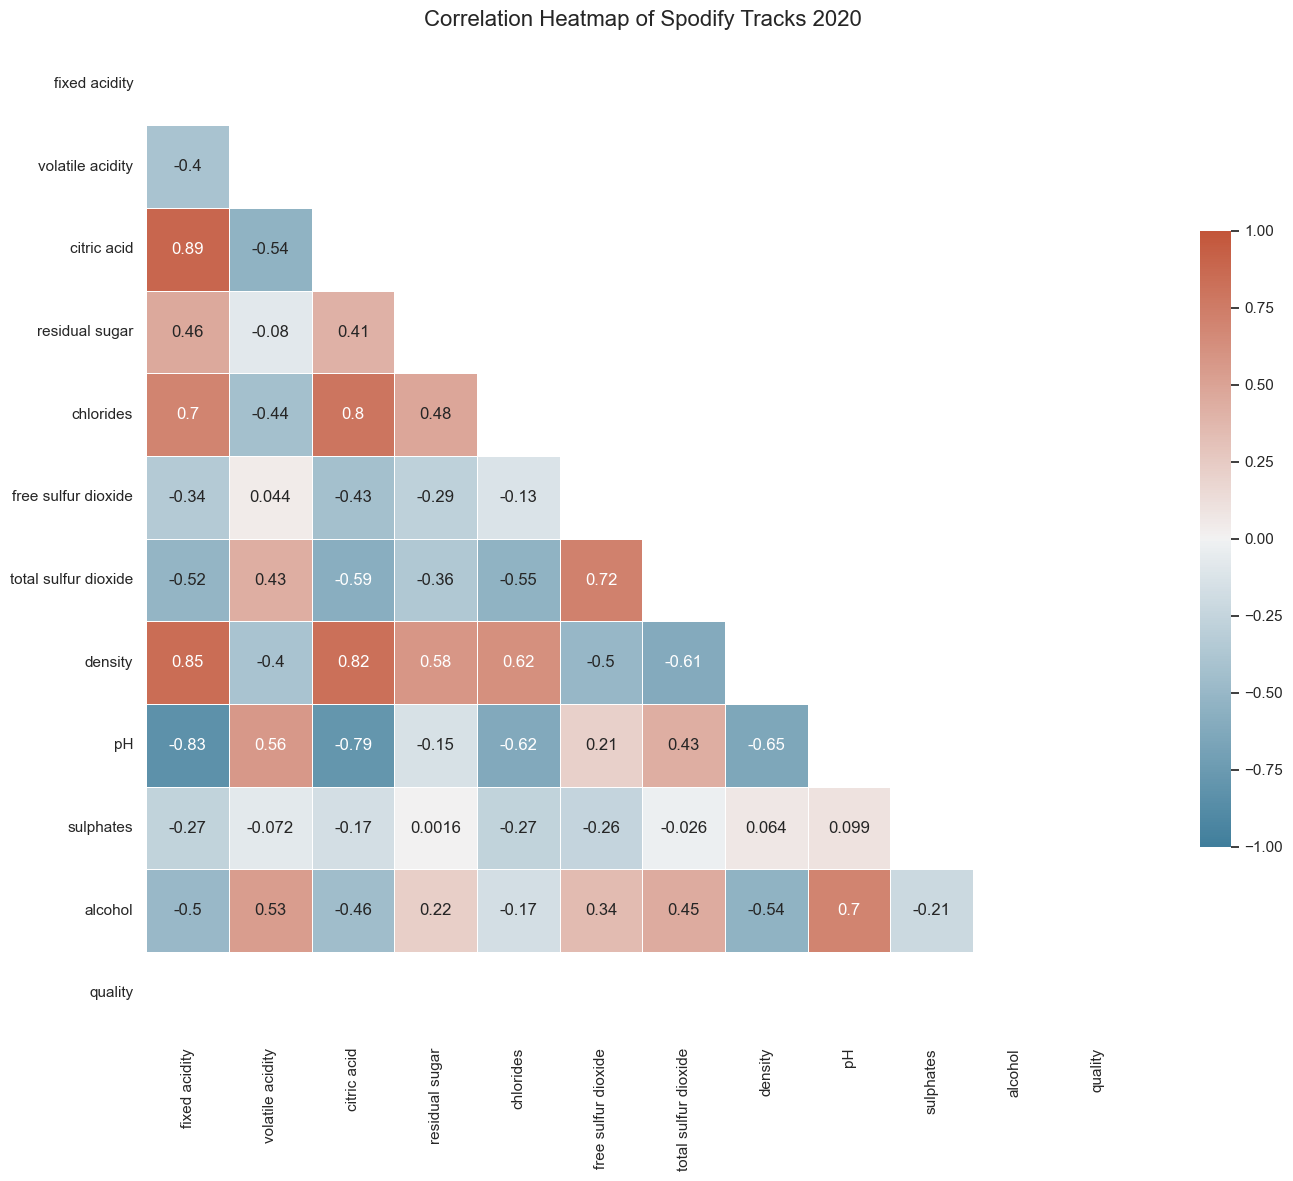

In [361]:
corr = eight.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(16, 16))

cmap = sns.diverging_palette(230, 20, as_cmap=True)
heatmap = sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=1,
    vmin=-1,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    annot=True,
)

heatmap.set_title(
    "Correlation Heatmap of Spodify Tracks 2020",
    fontdict={"fontsize": 16},
    pad=12,
)
plt.xlabel("")
plt.ylabel("")

# Two Groups

In [362]:
redwine["quality"] = redwine["quality"].replace([7, 8], 1)
redwine["quality"] = redwine["quality"].replace([3, 4, 5, 6, 7], 0)

# Data Normalization

In [363]:
scaler = MinMaxScaler()

scaled_redwine_logistic = scaler.fit_transform(redwine)
scaled_redwine_logistic = pd.DataFrame(
    scaled_redwine_logistic,
    columns=[
        "fixed acidity",
        "volatile acidity",
        "citric acid",
        "residual sugar",
        "chlorides",
        "free sulfur dioxide",
        "total sulfur dioxide",
        "density",
        "pH",
        "sulphates",
        "alcohol",
        "quality",
    ],
)

scaled_redwine_logistic.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0.248,0.397,0.000,0.068,0.107,0.141,0.099,0.568,0.606,0.138,0.154,0.000
1,0.283,0.521,0.000,0.116,0.144,0.338,0.216,0.494,0.362,0.210,0.215,0.000
2,0.283,0.438,0.040,0.096,0.134,0.197,0.170,0.509,0.409,0.192,0.215,0.000
3,0.584,0.110,0.560,0.068,0.105,0.225,0.191,0.582,0.331,0.150,0.215,0.000
4,0.248,0.397,0.000,0.068,0.107,0.141,0.099,0.568,0.606,0.138,0.154,0.000


# Hypothesis Testing

# Logistic Regression

# Functions

### Feature Columns

In [364]:
def feature_columns(feature_cols, dependent_variable):

    X = scaled_redwine_logistic[feature_cols]
    y = scaled_redwine_logistic[dependent_variable]

    return X, y

### Random Over Sampler

In [365]:
def random_oversampler(X, y):
    oversample = RandomOverSampler(sampling_strategy="minority")
    oversample = RandomOverSampler(sampling_strategy="auto")
    steps = [("over", RandomOverSampler()), ("model", LogisticRegression())]
    pipeline = Pipeline(steps=steps)
    X, y = oversample.fit_resample(X, y)

    return X, y

### Logistic Regression Model

In [366]:
def logistic_regression_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, shuffle=True, test_size=0.4, random_state=0
    )
    log_model = LogisticRegression(solver="liblinear", random_state=None)
    log_model.fit(X_train, y_train)
    y_predict = log_model.predict(X_test)

    return log_model, X_test, y_test, y_predict

### Confusion Matrix

In [367]:
def print_confusion_matrix(y_test, y_predict):
    print(confusion_matrix(y_test, y_predict))

### Classification Report

In [368]:
def print_classification_report(y_test, y_predict):
    print(classification_report(y_test, y_predict))

### Receiver Operating Characteristic (ROC) Curve

In [369]:
def display_roc_curve(log_model, X_test, y_test, y_predict):
    logit_roc_auc = roc_auc_score(y_test, y_predict)
    fpr, tpr, thresholds = roc_curve(y_test, log_model.predict_proba(X_test)[:, 1])

    plt.figure()
    plt.plot(fpr, tpr, label="Logistic Regression (area = %0.2f)" % logit_roc_auc)
    plt.plot([0, 1], [0, 1], "r--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.legend(loc="lower right")
    plt.savefig("Log_ROC")

    plt.show()

## Citric Acid

In [370]:
feature_cols = [
    "citric acid",
]

dependent_variable = "quality"

X, y = feature_columns(feature_cols, dependent_variable)
X, y = random_oversampler(X, y)
log_model, X_test, y_test, y_predict = logistic_regression_model(X, y)

### Reports

In [371]:
print_confusion_matrix(y_test, y_predict)

[[344 222]
 [136 404]]


In [372]:
print_classification_report(y_test, y_predict)

              precision    recall  f1-score   support

         0.0       0.72      0.61      0.66       566
         1.0       0.65      0.75      0.69       540

    accuracy                           0.68      1106
   macro avg       0.68      0.68      0.68      1106
weighted avg       0.68      0.68      0.67      1106



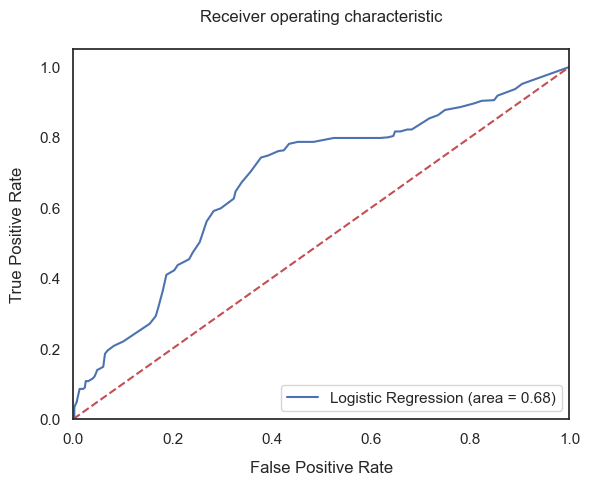

In [373]:
display_roc_curve(log_model, X_test, y_test, y_predict)

## Density


In [374]:
feature_cols = [
    "density",
]

dependent_variable = "quality"

X, y = feature_columns(feature_cols, dependent_variable)
X, y = random_oversampler(X, y)
log_model, X_test, y_test, y_predict = logistic_regression_model(X, y)

### Reports

In [375]:
print_confusion_matrix(y_test, y_predict)

[[309 257]
 [212 328]]


In [376]:
print_classification_report(y_test, y_predict)

              precision    recall  f1-score   support

         0.0       0.59      0.55      0.57       566
         1.0       0.56      0.61      0.58       540

    accuracy                           0.58      1106
   macro avg       0.58      0.58      0.58      1106
weighted avg       0.58      0.58      0.58      1106



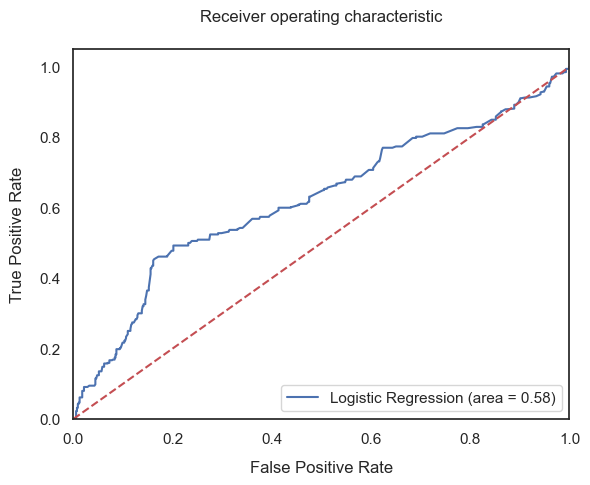

In [377]:
display_roc_curve(log_model, X_test, y_test, y_predict)

## Fixed Acidity


In [378]:
feature_cols = [
    "fixed acidity",
]

dependent_variable = "quality"

X, y = feature_columns(feature_cols, dependent_variable)
X, y = random_oversampler(X, y)
log_model, X_test, y_test, y_predict = logistic_regression_model(X, y)

### Reports

In [379]:
print_confusion_matrix(y_test, y_predict)

[[343 223]
 [220 320]]


In [380]:
print_classification_report(y_test, y_predict)

              precision    recall  f1-score   support

         0.0       0.61      0.61      0.61       566
         1.0       0.59      0.59      0.59       540

    accuracy                           0.60      1106
   macro avg       0.60      0.60      0.60      1106
weighted avg       0.60      0.60      0.60      1106



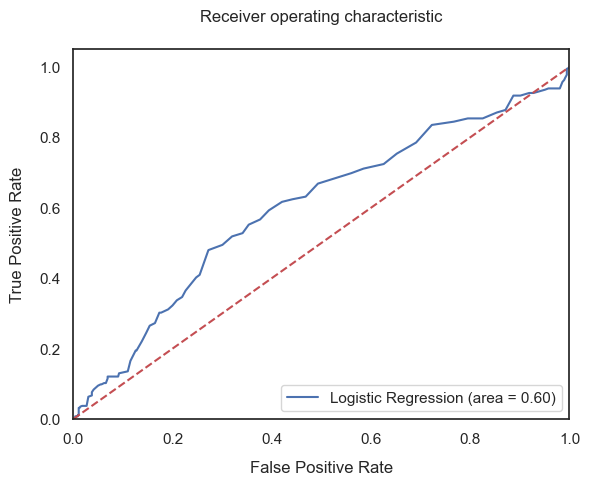

In [381]:
display_roc_curve(log_model, X_test, y_test, y_predict)

## Chlorides


In [382]:
feature_cols = [
    "chlorides",
]

dependent_variable = "quality"

X, y = feature_columns(feature_cols, dependent_variable)
X, y = random_oversampler(X, y)
log_model, X_test, y_test, y_predict = logistic_regression_model(X, y)

### Reports

In [383]:
print_confusion_matrix(y_test, y_predict)

[[156 410]
 [ 90 450]]


In [384]:
print_classification_report(y_test, y_predict)

              precision    recall  f1-score   support

         0.0       0.63      0.28      0.38       566
         1.0       0.52      0.83      0.64       540

    accuracy                           0.55      1106
   macro avg       0.58      0.55      0.51      1106
weighted avg       0.58      0.55      0.51      1106



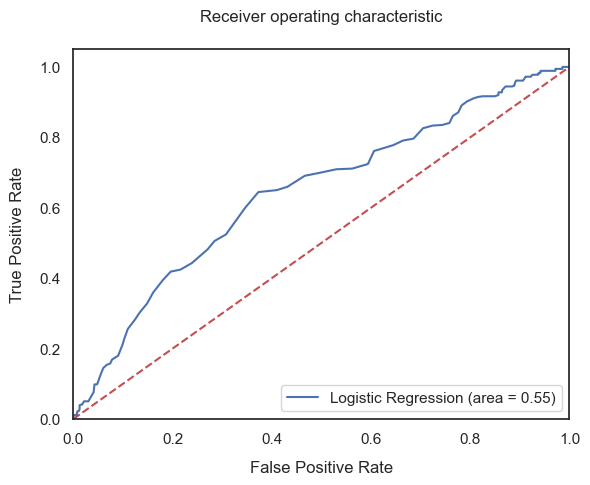

In [385]:
display_roc_curve(log_model, X_test, y_test, y_predict)

## Sulphates


In [386]:
feature_cols = [
    "sulphates",
]

dependent_variable = "quality"

X, y = feature_columns(feature_cols, dependent_variable)
X, y = random_oversampler(X, y)
log_model, X_test, y_test, y_predict = logistic_regression_model(X, y)

### Reports

In [387]:
print_confusion_matrix(y_test, y_predict)

[[404 162]
 [167 373]]


In [388]:
print_classification_report(y_test, y_predict)

              precision    recall  f1-score   support

         0.0       0.71      0.71      0.71       566
         1.0       0.70      0.69      0.69       540

    accuracy                           0.70      1106
   macro avg       0.70      0.70      0.70      1106
weighted avg       0.70      0.70      0.70      1106



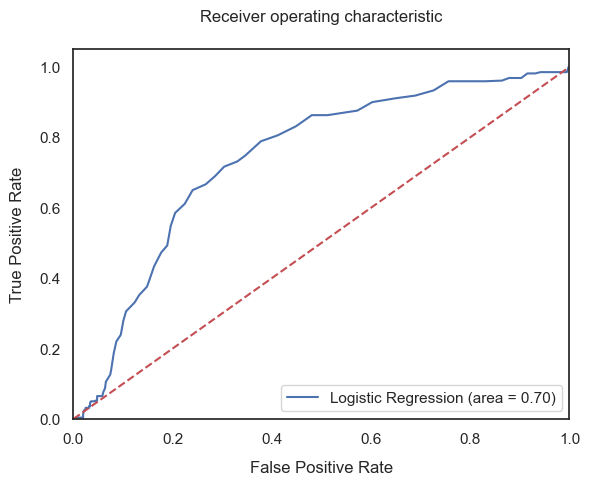

In [389]:
display_roc_curve(log_model, X_test, y_test, y_predict)

## Total Sulfur Dioxide

In [390]:
feature_cols = [
    "total sulfur dioxide",
]

dependent_variable = "quality"

X, y = feature_columns(feature_cols, dependent_variable)
X, y = random_oversampler(X, y)
log_model, X_test, y_test, y_predict = logistic_regression_model(X, y)

### Reports

In [391]:
print_confusion_matrix(y_test, y_predict)

[[247 319]
 [126 414]]


In [392]:
print_classification_report(y_test, y_predict)

              precision    recall  f1-score   support

         0.0       0.66      0.44      0.53       566
         1.0       0.56      0.77      0.65       540

    accuracy                           0.60      1106
   macro avg       0.61      0.60      0.59      1106
weighted avg       0.61      0.60      0.59      1106



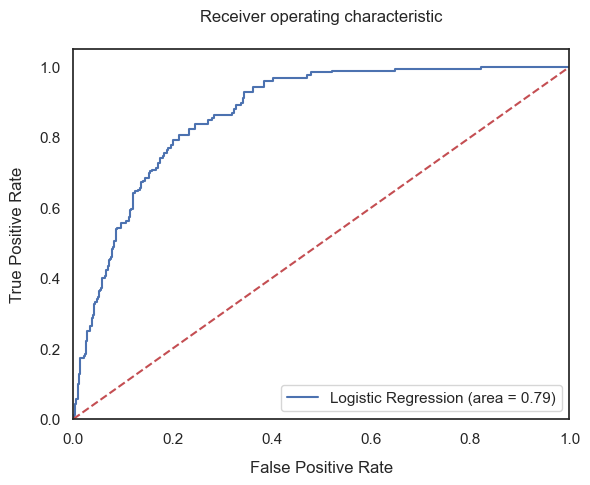

In [413]:
display_roc_curve(log_model, X_test, y_test, y_predict)

## Free Sulfur Dioxide

In [414]:
feature_cols = [
    "free sulfur dioxide",
]

dependent_variable = "quality"

X, y = feature_columns(feature_cols, dependent_variable)
X, y = random_oversampler(X, y)
log_model, X_test, y_test, y_predict = logistic_regression_model(X, y)

### Reports

In [415]:
print_confusion_matrix(y_test, y_predict)

[[200 366]
 [134 406]]


In [416]:
print_classification_report(y_test, y_predict)

              precision    recall  f1-score   support

         0.0       0.60      0.35      0.44       566
         1.0       0.53      0.75      0.62       540

    accuracy                           0.55      1106
   macro avg       0.56      0.55      0.53      1106
weighted avg       0.56      0.55      0.53      1106



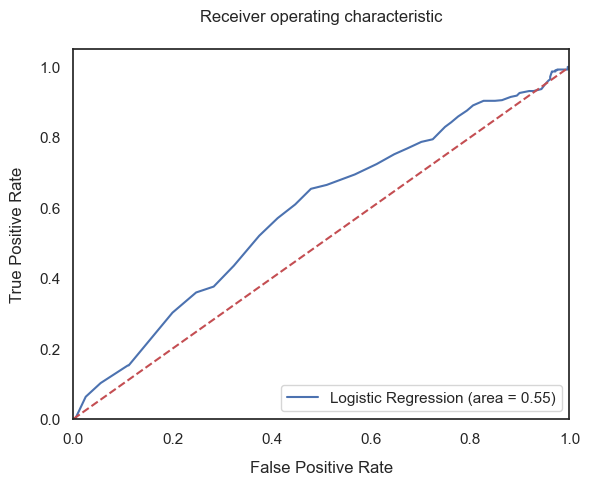

In [417]:
display_roc_curve(log_model, X_test, y_test, y_predict)

## Alcohol

In [418]:
feature_cols = [
    "alcohol",
]

dependent_variable = "quality"

X, y = feature_columns(feature_cols, dependent_variable)
X, y = random_oversampler(X, y)
log_model, X_test, y_test, y_predict = logistic_regression_model(X, y)

### Reports

In [419]:
print_confusion_matrix(y_test, y_predict)

[[396 170]
 [126 414]]


In [420]:
print_classification_report(y_test, y_predict)

              precision    recall  f1-score   support

         0.0       0.76      0.70      0.73       566
         1.0       0.71      0.77      0.74       540

    accuracy                           0.73      1106
   macro avg       0.73      0.73      0.73      1106
weighted avg       0.73      0.73      0.73      1106



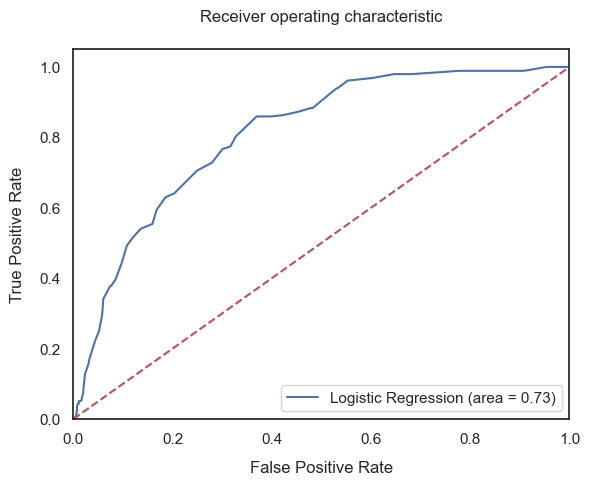

In [421]:
display_roc_curve(log_model, X_test, y_test, y_predict)

## pH

In [422]:
feature_cols = [
    "pH",
]

dependent_variable = "quality"

X, y = feature_columns(feature_cols, dependent_variable)
X, y = random_oversampler(X, y)
log_model, X_test, y_test, y_predict = logistic_regression_model(X, y)

### Reports

In [423]:
print_confusion_matrix(y_test, y_predict)

[[231 335]
 [157 383]]


In [424]:
print_classification_report(y_test, y_predict)

              precision    recall  f1-score   support

         0.0       0.60      0.41      0.48       566
         1.0       0.53      0.71      0.61       540

    accuracy                           0.56      1106
   macro avg       0.56      0.56      0.55      1106
weighted avg       0.57      0.56      0.55      1106



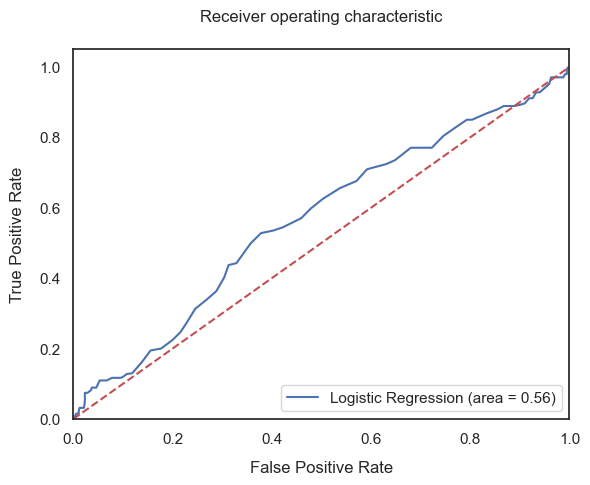

In [425]:
display_roc_curve(log_model, X_test, y_test, y_predict)

## Multivariant Logistic Regression

In [426]:
feature_cols = [
    "citric acid",
    "volatile acidity",
    "residual sugar",
    "total sulfur dioxide",
    "sulphates",
    "alcohol",
]

dependent_variable = "quality"

X, y = feature_columns(feature_cols, dependent_variable)
X, y = random_oversampler(X, y)
log_model, X_test, y_test, y_predict = logistic_regression_model(X, y)

In [427]:
feature_cols = [
    "citric acid",
    "volatile acidity",
    "residual sugar",
    "total sulfur dioxide",
    "sulphates",
    "pH",
]

X = redwine[feature_cols]
y = redwine.alcohol

### Reports

In [428]:
print_confusion_matrix(y_test, y_predict)

[[432 134]
 [ 94 446]]


In [429]:
print_classification_report(y_test, y_predict)

              precision    recall  f1-score   support

         0.0       0.82      0.76      0.79       566
         1.0       0.77      0.83      0.80       540

    accuracy                           0.79      1106
   macro avg       0.80      0.79      0.79      1106
weighted avg       0.80      0.79      0.79      1106



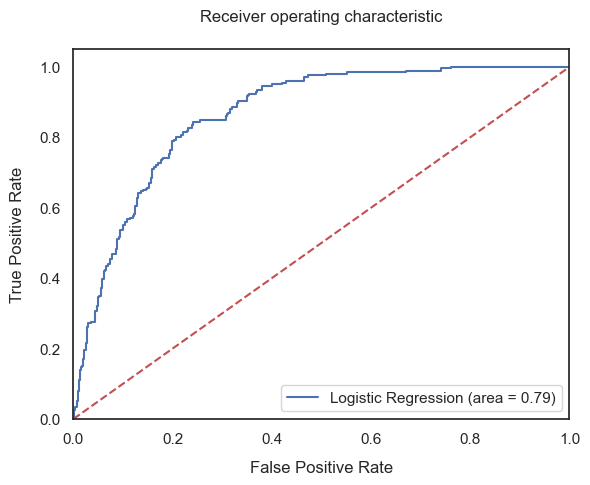

In [430]:
display_roc_curve(log_model, X_test, y_test, y_predict)

# Linear Regression

## Data Normalization

In [431]:
scaler = MinMaxScaler()
scaled_redwine_linear = scaler.fit_transform(redwine)
scaled_redwine_linear = pd.DataFrame(scaled_redwine_linear, columns = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'])

In [432]:
scaled_redwine_linear = scaled_redwine_linear.drop('quality', axis=1)

## Functions

### Feature Columns

In [433]:
def feature_columns(feature_cols, dependent_variable):

    X = scaled_redwine_linear[feature_cols]
    y = scaled_redwine_linear[dependent_variable]

    return X, y

### Linear Regression

In [434]:
def linear_regression_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=True, test_size=0.2, random_state=0)
    log_model = LinearRegression()
    log_model.fit(X_train, y_train)
    y_predict = log_model.predict(X_test)
    
    return log_model, X_train, X_test, y_train, y_test, y_predict

### Print R Squared

In [435]:
def print_rsquared(y_test, y_predict):
    print('R Squared is: ', np.round(r2_score(y_test, y_predict),2))

## Citric Acid

In [456]:
feature_cols = [
    "citric acid",
]

dependent_variable = "alcohol"

X, y = feature_columns(feature_cols, dependent_variable)
log_model, X_train, X_test, y_train, y_test, y_predict = linear_regression_model(X, y)
print_rsquared(y_test, y_predict)

R Squared is:  0.01


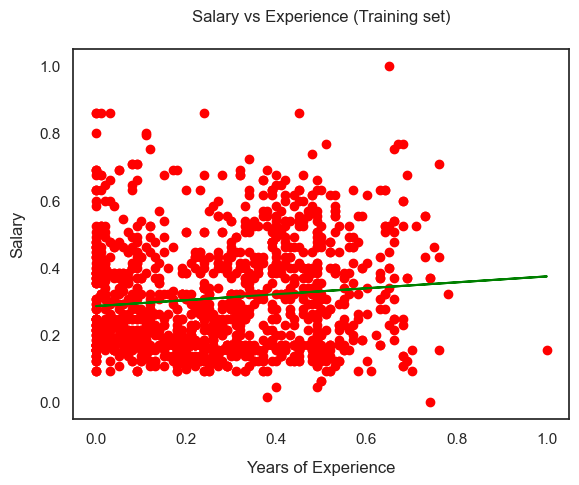

In [457]:
plt.scatter(X_train, y_train, color = "red")
plt.plot(X_train, log_model.predict(X_train), color = "green")
plt.title("Salary vs Experience (Training set)")
plt.xlabel("Years of Experience")
plt.ylabel("Salary")
plt.show()

## Density

In [458]:
feature_cols = [
    "density",
]

dependent_variable = "alcohol"

X, y = feature_columns(feature_cols, dependent_variable)
log_model, X_train, X_test, y_train, y_test, y_predict = linear_regression_model(X, y)
print_rsquared(y_test, y_predict)

R Squared is:  0.26


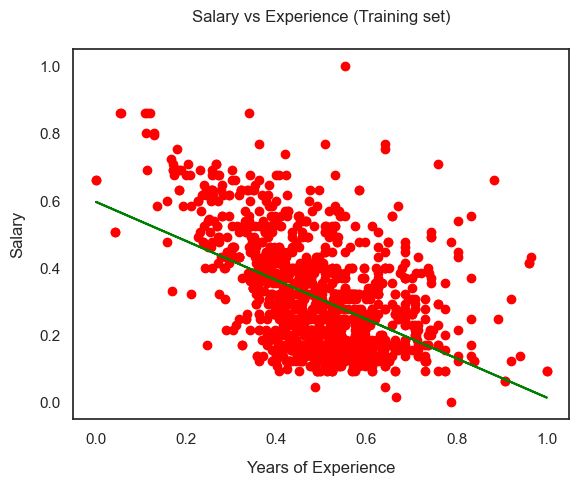

In [459]:
plt.scatter(X_train, y_train, color = "red")
plt.plot(X_train, log_model.predict(X_train), color = "green")
plt.title("Salary vs Experience (Training set)")
plt.xlabel("Years of Experience")
plt.ylabel("Salary")
plt.show()

## Fixed Acidity

In [461]:
feature_cols = [
    "fixed acidity",
]

dependent_variable = "alcohol"

X, y = feature_columns(feature_cols, dependent_variable)
log_model, X_train, X_test, y_train, y_test, y_predict = linear_regression_model(X, y)
print_rsquared(y_test, y_predict)

R Squared is:  0.0


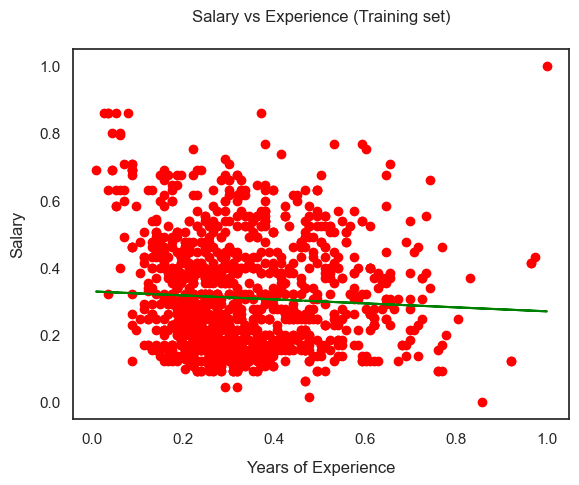

In [462]:
plt.scatter(X_train, y_train, color = "red")
plt.plot(X_train, log_model.predict(X_train), color = "green")
plt.title("Salary vs Experience (Training set)")
plt.xlabel("Years of Experience")
plt.ylabel("Salary")
plt.show()

## Sulphates

In [463]:
feature_cols = [
    "sulphates",
]

dependent_variable = "alcohol"

X, y = feature_columns(feature_cols, dependent_variable)
log_model, X_train, X_test, y_train, y_test, y_predict = linear_regression_model(X, y)
print_rsquared(y_test, y_predict)

R Squared is:  0.0


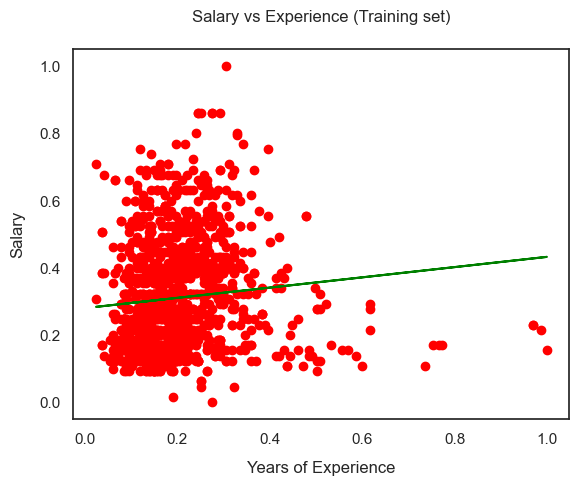

In [464]:
plt.scatter(X_train, y_train, color = "red")
plt.plot(X_train, log_model.predict(X_train), color = "green")
plt.title("Salary vs Experience (Training set)")
plt.xlabel("Years of Experience")
plt.ylabel("Salary")
plt.show()

## Chlorides

In [465]:
feature_cols = [
    "chlorides",
]

dependent_variable = "alcohol"

X, y = feature_columns(feature_cols, dependent_variable)
log_model, X_train, X_test, y_train, y_test, y_predict = linear_regression_model(X, y)
print_rsquared(y_test, y_predict)

R Squared is:  0.07


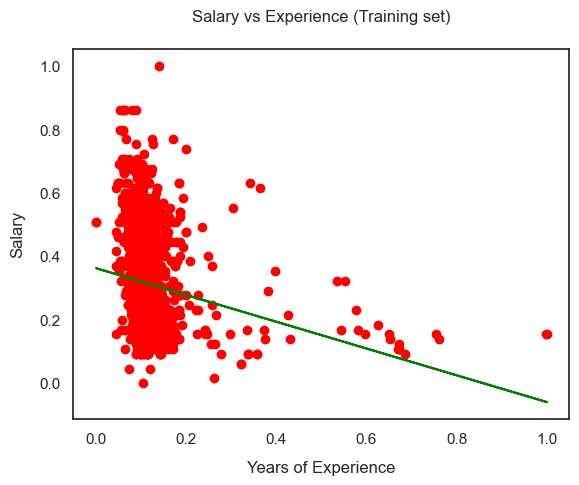

In [466]:
plt.scatter(X_train, y_train, color = "red")
plt.plot(X_train, log_model.predict(X_train), color = "green")
plt.title("Salary vs Experience (Training set)")
plt.xlabel("Years of Experience")
plt.ylabel("Salary")
plt.show()

## Total Sulfur Dioxide

In [467]:
feature_cols = [
    "total sulfur dioxide",
]

dependent_variable = "alcohol"

X, y = feature_columns(feature_cols, dependent_variable)
log_model, X_train, X_test, y_train, y_test, y_predict = linear_regression_model(X, y)
print_rsquared(y_test, y_predict)

R Squared is:  0.03


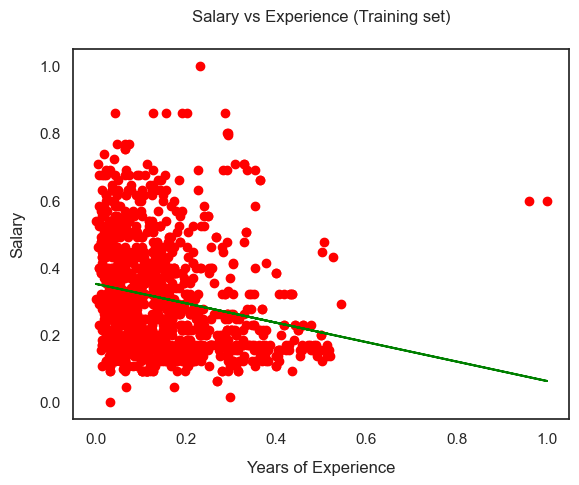

In [468]:
plt.scatter(X_train, y_train, color = "red")
plt.plot(X_train, log_model.predict(X_train), color = "green")
plt.title("Salary vs Experience (Training set)")
plt.xlabel("Years of Experience")
plt.ylabel("Salary")
plt.show()

## Free Sulfur Dioxide

In [469]:
feature_cols = [
    "free sulfur dioxide",
]

dependent_variable = "alcohol"

X, y = feature_columns(feature_cols, dependent_variable)
log_model, X_train, X_test, y_train, y_test, y_predict = linear_regression_model(X, y)
print_rsquared(y_test, y_predict)

R Squared is:  -0.01


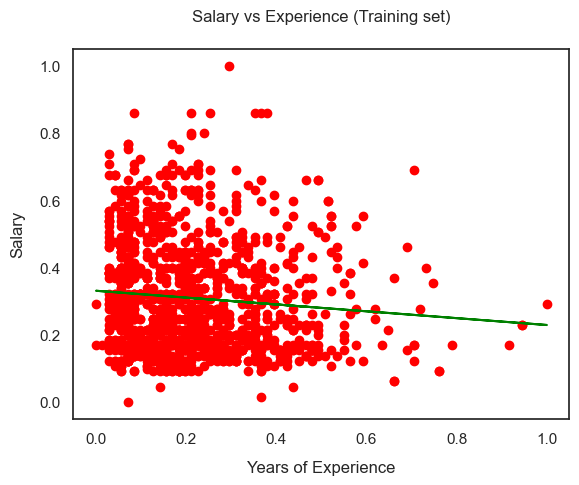

In [470]:
plt.scatter(X_train, y_train, color = "red")
plt.plot(X_train, log_model.predict(X_train), color = "green")
plt.title("Salary vs Experience (Training set)")
plt.xlabel("Years of Experience")
plt.ylabel("Salary")
plt.show()

## pH

In [471]:
feature_cols = [
    "pH",
]

dependent_variable = "alcohol"

X, y = feature_columns(feature_cols, dependent_variable)
log_model, X_train, X_test, y_train, y_test, y_predict = linear_regression_model(X, y)
print_rsquared(y_test, y_predict)

R Squared is:  0.05


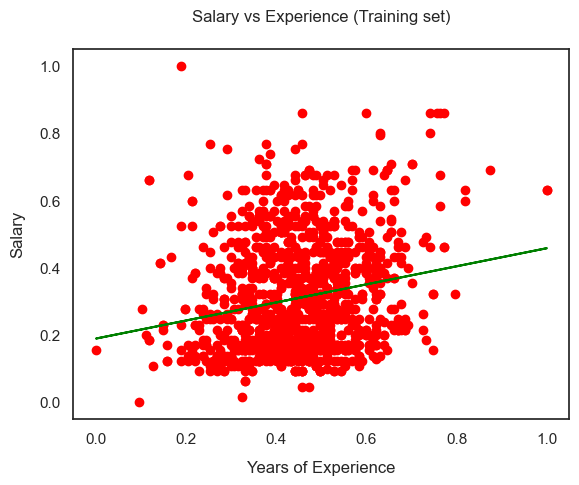

In [472]:
plt.scatter(X_train, y_train, color = "red")
plt.plot(X_train, log_model.predict(X_train), color = "green")
plt.title("Salary vs Experience (Training set)")
plt.xlabel("Years of Experience")
plt.ylabel("Salary")
plt.show()

## Multivariant Linear Regression

In [449]:
feature_cols = [
    "density",
    "volatile acidity",
    "residual sugar",
    "total sulfur dioxide",
    "chlorides",
    "pH",
]

dependent_variable = "alcohol"

X, y = feature_columns(feature_cols, dependent_variable)
log_model, X_train, X_test, y_train, y_test, y_predict = linear_regression_model(X, y)
print_rsquared(y_test, y_predict)

R Squared is:  0.44


In [450]:
log_model.score(X,y)

0.39057466480790026

In [451]:
X_train.head()

,density,volatile acidity,residual sugar,total sulfur dioxide,chlorides,pH
642,0.663,0.288,0.096,0.120,0.098,0.512
679,0.523,0.096,0.164,0.152,0.080,0.307
473,0.516,0.158,0.082,0.028,0.083,0.409
390,0.171,0.500,0.034,0.290,0.055,0.646
1096,0.476,0.414,0.315,0.039,0.175,0.480


In [332]:
y_train.head()

642    0.154
679    0.185
473    0.338
390    0.692
1096   0.369
Name: alcohol, dtype: float64

In [ ]:
plt.scatter(X_train, y_train, color = "red")
plt.plot(X_train, log_model.predict(X_train), color = "green")
plt.title("Salary vs Experience (Training set)")
plt.xlabel("Years of Experience")
plt.ylabel("Salary")
plt.show()